### Prerequsite - Upgrade Scikit Learn
The current workspace has scikit-learn v0.19.1 installed. However, you can upgrade scikit-learn to 0.24.x. and use this [OneHotEncoder](https://scikit-learn.org/0.21/modules/generated/sklearn.preprocessing.OneHotEncoder.html) library. 


In [1]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.19.1.


In [2]:
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

In [3]:
!python -m pip install --upgrade scikit-learn
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

Requirement already up-to-date: scikit-learn in /opt/conda/lib/python3.6/site-packages (0.24.2)
The scikit-learn version is 0.24.2.


In [4]:
# Now you can import and use OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
# your code goes here

In [5]:
# Similarly, should you need any other package, they can install it as:
!python -m pip install 'tensorflow-tensorboard<0.2.0,>=0.1.0'

    100% |████████████████████████████████| 1.6MB 13.0MB/s ta 0:00:01


# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [13]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown
import ast # to parse string list to list
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''
pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [14]:
# Load in the general demographics data.
gp_df  = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [15]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
gp_df.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [16]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [17]:
# 1.1.1 # Identify missing or unknown data values and convert them to NaNs.
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,SEMIO_DOM,person,ordinal,[-1]
freq,1,43,49,26


In [18]:
feat_info.shape

(85, 4)

In [19]:
feat_info['missing_or_unknown'].unique()
# missing_or_unknown contain string representation of list 
# There are unique value X and XX exist inside the missing_or_unknown column

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

In [20]:
# Parse from string representation of list to actual Python list is required.

def parse_missing_or_unknown(value):
    # If value is a string that starts and ends with brackets
    if isinstance(value, str) and value.startswith('[') and value.endswith(']'):
        stripped_value = value.strip('[]')    # Remove brackets, split content by commas
        if stripped_value:
            return stripped_value.split(',')       
        else:
            return [] # return empty list if stripped value is empty
    return None  # Return None for invalid or non-string values

# Apply the function to the 'missing_or_unknown' column
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(parse_missing_or_unknown)

In [21]:
# Ensure all entries are lists
print(feat_info['missing_or_unknown'].apply(lambda x: isinstance(x, list)).all())

True


In [22]:
# Find rows where 'missing_or_unknown' is an empty list
rows_with_empty_missing_vals  = feat_info[feat_info['missing_or_unknown'].str.len() == 0]
# Display the rows with empty lists
print(rows_with_empty_missing_vals)

             attribute information_level         type missing_or_unknown
12     GFK_URLAUBERTYP            person  categorical                 []
13    GREEN_AVANTGARDE            person  categorical                 []
44        ANZ_PERSONEN         household      numeric                 []
45           ANZ_TITEL         household      numeric                 []
51        ANZ_HH_TITEL          building      numeric                 []
53         KONSUMNAEHE          building      ordinal                 []
69  GEBAEUDETYP_RASTER        region_rr1      ordinal                 []
71          MOBI_REGIO        region_rr1      ordinal                 []
72   ONLINE_AFFINITAET        region_rr1      ordinal                 []
74    KBA13_ANZAHL_PKW    macrocell_plz8      numeric                 []


In [23]:
# Create a dictionary for valid missing values
valid_missing_featinfo = feat_info[feat_info['missing_or_unknown'].str.len() > 0]
missing_values_by_attr = valid_missing_featinfo.set_index('attribute')['missing_or_unknown'].to_dict()

In [24]:
cleaned_gp_df = gp_df.replace(missing_values_by_attr, np.nan)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [25]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# Missing values count per column
missing_val_count_per_col = cleaned_gp_df.isna().sum()

print("Missing values count per column:")
print(missing_val_count_per_col)

Missing values count per column:
AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_E

In [26]:
# Missing value percentage per column
missing_val_pct_per_col  = (missing_val_count_per_col / len(cleaned_gp_df)) * 100

# Display missing data percentages per feature
print("Missing data percentage per feature in general demographic data:")
print(missing_val_pct_per_col)

Missing data percentage per feature in general demographic data:
AGER_TYP                  0.000000
ALTERSKATEGORIE_GROB      0.000000
ANREDE_KZ                 0.000000
CJT_GESAMTTYP             0.544646
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_VORSORGER          0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
FINANZTYP                 0.000000
GEBURTSJAHR               0.000000
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE          0.000000
HEALTH_TYP                0.000000
LP_LEBENSPHASE_FEIN       0.544646
LP_LEBENSPHASE_GROB       0.544646
LP_FAMILIE_FEIN           0.544646
LP_FAMILIE_GROB           0.544646
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ          0.000000
PRAEGENDE_JUGENDJAHRE     0.000000
RETOURTYP_BK_S            0.544646
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
SEMIO_REL                

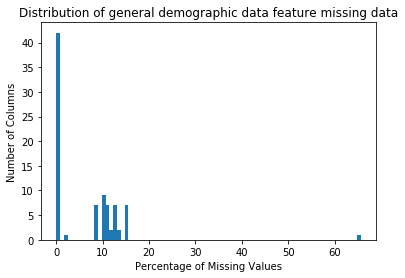

In [27]:
# Investigate patterns in the amount of missing data in each column.
# Visualize missing data distribution of the feature.
plt.hist(missing_val_pct_per_col, bins=80)
plt.title('Distribution of general demographic data feature missing data')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Number of Columns')
plt.show()

In [28]:
# Define threshold for missing data

# 12% Threshold value selected to remove feature outlier and keeping some.
col_missing_threshold  = 12

# Identify outlier feature.
col_outliers  = missing_val_pct_per_col[missing_val_pct_per_col  > col_missing_threshold].index

# Save list of removed feature
removed_feature = list(col_outliers)
print(f"Outlier columns in cleaned_az_data (>{col_missing_threshold}% missing):")
print(removed_feature)
print(f"Total count of : {len(col_outliers)} column")

Outlier columns in cleaned_az_data (>12% missing):
['KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_BAUMAX', 'KBA05_GBZ', 'KKK', 'MOBI_REGIO', 'REGIOTYP', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ']
Total count of : 18 column


In [29]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Drop outlier columns
cleaned_gp_df = cleaned_gp_df.drop(columns=col_outliers)

In [30]:
# Verify updated datasets
print(f"cleaned_gp_df after removal: {cleaned_gp_df.shape}")

cleaned_gp_df after removal: (891221, 67)


#### Discussion 1.1.2: Assess Missing Data in Each Column

The histogram shows most features have missing data below 12%, with an outlier at ~65%.

A 12% threshold was chosen to exclude columns with excessive missing data while retaining CAMEO_INTL_2015, which will be processed separately later.

After applying this threshold, the dataset retains 67 columns, ensuring data quality without prematurely removing relevant features.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [31]:
# How much data is missing in each row of the dataset?

# Calculate the percentage of missing data for each row
missing_val_count_per_row = cleaned_gp_df.isna().sum(axis=1)
missing_val_pct_per_row = (missing_val_count_per_row / cleaned_gp_df.shape[1]) * 100

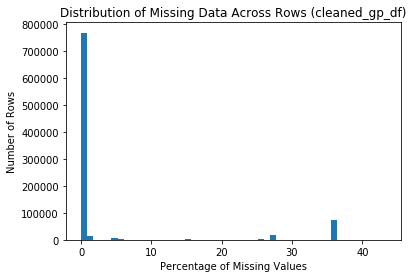

In [32]:
# Plot histogram
plt.hist(missing_val_pct_per_row, bins=50)
plt.title('Distribution of Missing Data Across Rows (cleaned_gp_df)')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Number of Rows')
plt.show()

In [33]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Define threshold for missing data
row_missing_thresh = 5

# Create two subsets: one above and one below  threshold
gp_above_thresh_df  = cleaned_gp_df[missing_val_pct_per_row > row_missing_thresh]
gp_below_thresh_df  = cleaned_gp_df[missing_val_pct_per_row <= row_missing_thresh]

# Display the number of rows in each subset
print(f"Rows with >{row_missing_thresh}% missing data: {gp_above_thresh_df.shape[0]}")
print(f"Rows with <={row_missing_thresh}% missing data: {gp_below_thresh_df.shape[0]}")

Rows with >5% missing data: 100294
Rows with <=5% missing data: 790927


Columns selected for cleaned_gp_df comparison: Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST'],
      dtype='object')


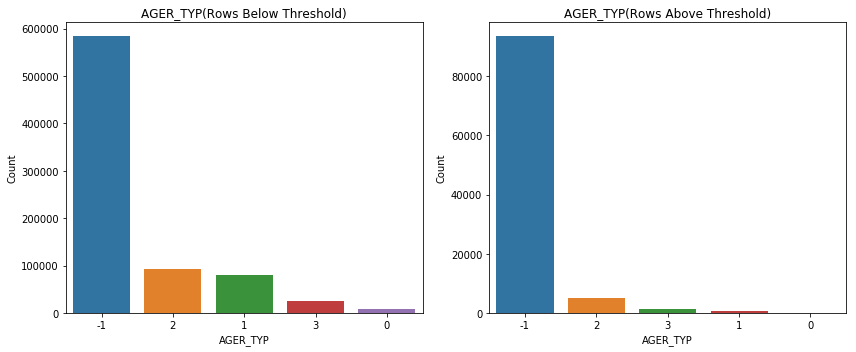

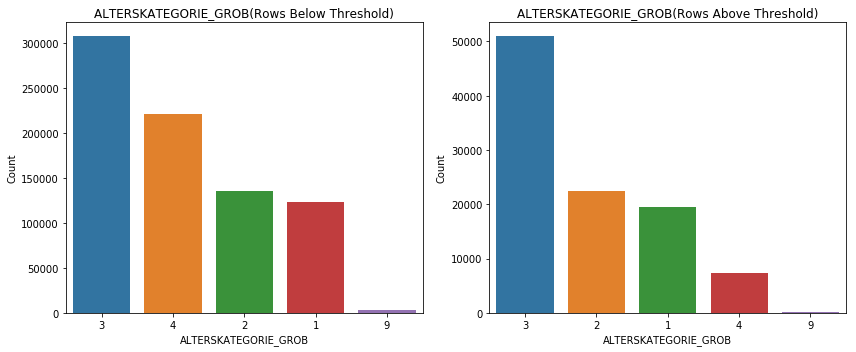

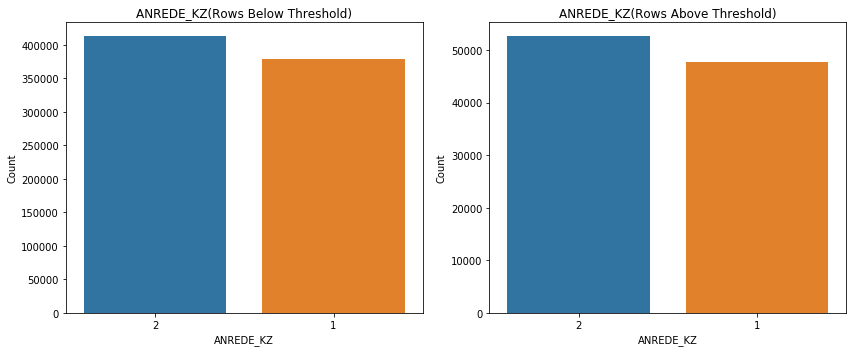

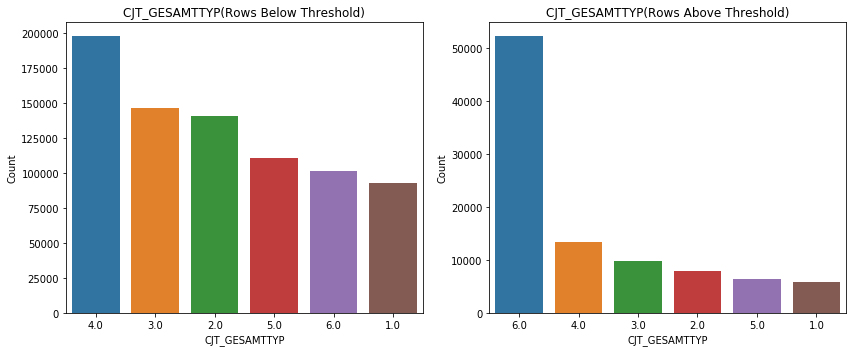

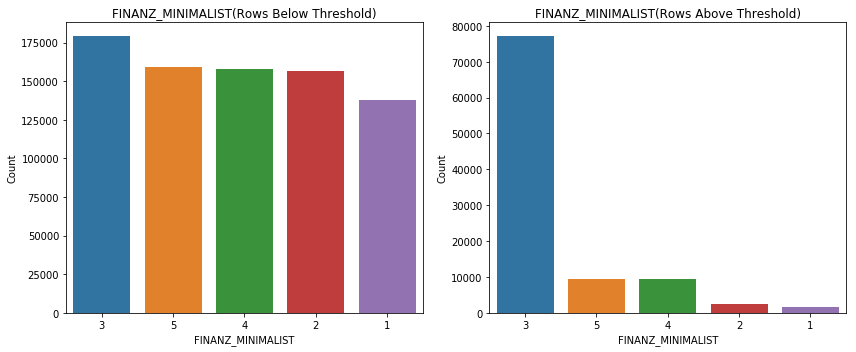

In [34]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Function to compare distribution
def compare_column_distribution(column, subset_below, subset_above):
    plt.figure(figsize=(12, 5))
    
    # Plot Rows Below Threshold
    plt.subplot(1, 2, 1)
    sns.countplot(x=subset_below[column].dropna(), 
                  order=subset_below[column].value_counts().index)
    plt.title(f'{column}(Rows Below Threshold)')
    plt.xlabel(column)
    plt.ylabel('Count')

    # Plot Rows Above Threshold
    plt.subplot(1, 2, 2)
    sns.countplot(x=subset_above[column].dropna(), 
                  order=subset_above[column].value_counts().index)
    plt.title(f'{column}(Rows Above Threshold)')
    plt.xlabel(column)
    plt.ylabel('Count')

    # Adjust layout
    plt.tight_layout()
    plt.show()
    
# Select columns with minimal missing data
top_5_low_missing_cols = cleaned_gp_df.columns[cleaned_gp_df.isna().mean() < 0.1][:5]
print(f"Columns selected for cleaned_gp_df comparison: {top_5_low_missing_cols}")
    
for col in top_5_low_missing_cols:
    compare_column_distribution(col, gp_below_thresh_df, gp_above_thresh_df)

#### Discussion 1.1.3: Assess Missing Data in Each Row

The histogram shows that the majority of rows have less than 5% missing values:

Rows with ≤5% missing values: 790,927 (majority)
Rows with >5% missing values: 100,294

Applying a 5% threshold ensures the majority of the data is retained while excluding rows with excessive missing values, thereby improving data quality.

For features like AGER_TYP, FINANZ_MINIMALIST, and CJT_GESAMTTYP:

Rows above the threshold: Display skewed distributions with limited analytical value due to incomplete data.

Rows below the threshold: Show balanced distributions, ensuring better representation for meaningful analysis.

Rows with >5% missing data add minimal value and are excluded to maintain a reliable dataset for analysis.

## Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [35]:
# How many features are there of each data type?

# Get list of attributes in cleaned dataset
valid_gp_attr  = gp_below_thresh_df.columns.tolist() 

# Filter feature information for valid attributes
valid_gp_feat_info  = feat_info[feat_info['attribute'].isin(valid_gp_attr)]

# Get data type counts
gp_feature_type_counts = valid_gp_feat_info['type'].value_counts()
print(gp_feature_type_counts)

ordinal        34
categorical    20
numeric         7
mixed           5
interval        1
Name: type, dtype: int64


In [36]:
categorical_features = valid_gp_feat_info[valid_gp_feat_info['type'] == 'categorical']['attribute'].tolist()

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [37]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

binary_categorical_cols = []
multi_categorical_cols = []

# Classify categorical columns
for col in categorical_features:
    unique_count = gp_below_thresh_df[col].nunique()
    if unique_count == 2:
        binary_categorical_cols.append(col)
    elif unique_count > 2:
        multi_categorical_cols.append(col)

# Display the identified columns
print(f"Binary categorical columns: {binary_categorical_cols}")
print(f"Multi-level categorical columns: {multi_categorical_cols}")

Binary categorical columns: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']
Multi-level categorical columns: ['AGER_TYP', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [38]:
def inspect_unique_values(df, columns, column_type="categorical"):
    for col in columns:
        unique_values = df[col].unique()
        print(f"[{column_type.capitalize()} Column] '{col}' has unique values: {unique_values}")

# Inspect binary categorical columns
inspect_unique_values(gp_below_thresh_df, binary_categorical_cols, column_type="binary")

# Inspect multi-level categorical columns
inspect_unique_values(gp_below_thresh_df, multi_categorical_cols, column_type="multi-level")

[Binary Column] 'ANREDE_KZ' has unique values: [2 1]
[Binary Column] 'GREEN_AVANTGARDE' has unique values: [0 1]
[Binary Column] 'SOHO_KZ' has unique values: [1. 0.]
[Binary Column] 'OST_WEST_KZ' has unique values: ['W' 'O']
[Multi-level Column] 'AGER_TYP' has unique values: [-1  2  3  0  1]
[Multi-level Column] 'CJT_GESAMTTYP' has unique values: [5. 3. 2. 4. 1. 6.]
[Multi-level Column] 'FINANZTYP' has unique values: [1 6 5 2 4 3]
[Multi-level Column] 'GFK_URLAUBERTYP' has unique values: [10.  1.  5. 12.  9.  3.  8. 11.  4.  7.  2.  6.]
[Multi-level Column] 'LP_FAMILIE_FEIN' has unique values: [ 5.  1.  0. 10.  2.  7. 11.  8.  4.  6.  9.  3.]
[Multi-level Column] 'LP_FAMILIE_GROB' has unique values: [3. 1. 0. 5. 2. 4.]
[Multi-level Column] 'LP_STATUS_FEIN' has unique values: [ 2.  3.  9.  4.  1. 10.  5.  8.  6.  7.]
[Multi-level Column] 'LP_STATUS_GROB' has unique values: [1. 2. 4. 5. 3.]
[Multi-level Column] 'NATIONALITAET_KZ' has unique values: [1 3 2 0]
[Multi-level Column] 'SHOPPER

In [39]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Binary categorical cols: 
reencoded_gp_df = gp_below_thresh_df.copy()

# Re-encode the values as numbers
reencoded_gp_df['OST_WEST_KZ'] = reencoded_gp_df['OST_WEST_KZ'].map({'W': 0, 'O': 1})

In [40]:
# Drop multi-level categorical variables
reencoded_gp_df = reencoded_gp_df.drop(columns=multi_categorical_cols)

In [41]:
# Inspect modified dataset
print(reencoded_gp_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 790927 entries, 1 to 891220
Data columns (total 51 columns):
ALTERSKATEGORIE_GROB     790927 non-null int64
ANREDE_KZ                790927 non-null int64
FINANZ_MINIMALIST        790927 non-null int64
FINANZ_SPARER            790927 non-null int64
FINANZ_VORSORGER         790927 non-null int64
FINANZ_ANLEGER           790927 non-null int64
FINANZ_UNAUFFAELLIGER    790927 non-null int64
FINANZ_HAUSBAUER         790927 non-null int64
GEBURTSJAHR              790927 non-null int64
GREEN_AVANTGARDE         790927 non-null int64
HEALTH_TYP               790927 non-null int64
LP_LEBENSPHASE_FEIN      790927 non-null float64
LP_LEBENSPHASE_GROB      790927 non-null float64
PRAEGENDE_JUGENDJAHRE    790927 non-null int64
RETOURTYP_BK_S           790927 non-null float64
SEMIO_SOZ                790927 non-null int64
SEMIO_FAM                790927 non-null int64
SEMIO_REL                790927 non-null int64
SEMIO_MAT                790927 non-n

#### Discussion 1.2.1: Re-Encode Categorical Features

Binary Categorical Variables:
- Found 'OST_WEST_KZ' with unique values ['W', 'O'].
- Re-encoded: 'W' → 0, 'O' → 1 to standardize for numerical analysis.

Multi-Level Categorical Variables:
- Dropped all multi-level categorical variables (e.g., AGER_TYP, FINANZTYP) to avoid dimensionality issues and simplify analysis.

Final Dataset:
- Retained binary and numeric features only.
- Simplifies clustering while maintaining key insights for customer segmentation.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [42]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# Inspect 
unique_values = reencoded_gp_df['PRAEGENDE_JUGENDJAHRE'].unique()
print(f"Unique values in 'PRAEGENDE_JUGENDJAHRE': {unique_values}")

Unique values in 'PRAEGENDE_JUGENDJAHRE': [14 15  8  3 10 11  5  9  6  4  0  2  1 12 13  7]


In [43]:
# Map PRAEGENDE_JUGENDJAHRE to decades
decade_mapping = {
    1: 40, 2: 40,
    3: 50, 4: 50,
    5: 60, 6: 60, 7: 60,
    8: 70, 9: 70,
    10: 80, 11: 80, 12: 80, 13: 80,
    14: 90, 15: 90
}


def determine_movement(value):
    if value > 0 and value % 2 != 0:
        return 1  # Mainstream
    elif value > 0 and value % 2 == 0:
        return 2  # Avant-garde
    else:
        return -1  # Unknown
    
reencoded_gp_df['DECADE'] = reencoded_gp_df['PRAEGENDE_JUGENDJAHRE'].map(decade_mapping)
# Fill NaN with -1
reencoded_gp_df['DECADE'] = reencoded_gp_df['DECADE'].fillna(-1).astype(int)

reencoded_gp_df['MOVEMENT'] = reencoded_gp_df['PRAEGENDE_JUGENDJAHRE'].apply(determine_movement)

In [44]:
# Check results
print(reencoded_gp_df[['PRAEGENDE_JUGENDJAHRE', 'DECADE', 'MOVEMENT']].head())

   PRAEGENDE_JUGENDJAHRE  DECADE  MOVEMENT
1                     14      90         2
2                     15      90         1
3                      8      70         2
4                      8      70         2
5                      3      50         1


In [45]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# Inspect 
unique_values = reencoded_gp_df['CAMEO_INTL_2015'].unique()
print(f"Unique values in 'CAMEO_INTL_2015': {unique_values}")

Unique values in 'CAMEO_INTL_2015': ['51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25' nan
 '23' '31' '52' '35' '45' '44' '32']


In [46]:
# Replace NaN in 'CAMEO_INTL_2015' with a placeholder (e.g., '-1')
reencoded_gp_df['CAMEO_INTL_2015'] = reencoded_gp_df['CAMEO_INTL_2015'].fillna('-1')

# Ensure all entries are strings
reencoded_gp_df['CAMEO_INTL_2015'] = reencoded_gp_df['CAMEO_INTL_2015'].astype(str)

# Extract wealth (first digit) and handle non-numeric values
reencoded_gp_df['WEALTH'] = reencoded_gp_df['CAMEO_INTL_2015'].str[0].apply(lambda x: int(x) if x.isdigit() else -1)

# Extract life stage (second digit) and handle non-numeric values
reencoded_gp_df['LIFE_STAGE'] = reencoded_gp_df['CAMEO_INTL_2015'].str[1].apply(lambda x: int(x) if x.isdigit() else -1)

# Check results
print(reencoded_gp_df[['CAMEO_INTL_2015', 'WEALTH', 'LIFE_STAGE']].head())

  CAMEO_INTL_2015  WEALTH  LIFE_STAGE
1              51       5           1
2              24       2           4
3              12       1           2
4              43       4           3
5              54       5           4


#### Discussion 1.2.2: Engineer Mixed-Type Features

Create two new features from PRAEGENDE_JUGENDJAHRE.
- DECADE: Decade grouping based on youth era (e.g., 40s, 50s) for easier intepretation
- MOVEMENT: Differentiates mainstream (1) and avant-garde (2) and missing (-1)
 
Create two new feature from CAMEO_INTL_2015
- WEALTH: Extracted first digit for wealth categorization.
- LIFE_STAGE: Extracted second digit for life stage categorization.
  
Original columns (PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015) were dropped after feature extraction to avoid redundancy.

Engineering Steps:
- Mapped PRAEGENDE_JUGENDJAHRE to DECADE using a custom dictionary.
- Derived MOVEMENT using modular logic (odd = 1, even = 2, missing = -1).
- Filled missing values in CAMEO_INTL_2015 with -1 and extracted digits for WEALTH and LIFE_STAGE.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [47]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [48]:
# Drop original columns used for engineering
columns_to_drop = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']
final_gp_df = reencoded_gp_df.drop(columns=columns_to_drop, errors='ignore')

In [49]:
final_gp_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,ONLINE_AFFINITAET,KBA13_ANZAHL_PKW,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1,2,1,5,2,5,4,5,1996,0,3,21.0,6.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,0.0,2.0,0.0,6.0,9.0,11.0,0.0,1.0,1992.0,0,4.0,6.0,3.0,8.0,3.0,3.0,963.0,3.0,5.0,4.0,90,2,5,1
2,3,2,1,4,1,2,3,5,1979,1,3,3.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,17.0,1.0,0.0,4.0,9.0,10.0,0.0,5.0,1992.0,0,2.0,2.0,4.0,4.0,4.0,2.0,712.0,3.0,5.0,2.0,90,1,2,4
3,4,2,4,2,5,2,1,2,1957,0,2,0.0,0.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,13.0,0.0,0.0,1.0,9.0,1.0,0.0,4.0,1997.0,0,7.0,4.0,2.0,6.0,4.0,1.0,596.0,2.0,3.0,3.0,70,2,1,2
4,3,1,4,3,4,1,3,2,1963,0,3,32.0,10.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,20.0,4.0,0.0,5.0,9.0,3.0,0.0,4.0,1992.0,0,3.0,2.0,5.0,1.0,5.0,5.0,435.0,4.0,6.0,5.0,70,2,4,3
5,1,2,3,1,5,2,2,5,1943,0,3,8.0,2.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,10.0,1.0,0.0,5.0,9.0,5.0,0.0,5.0,1992.0,0,7.0,6.0,2.0,7.0,4.0,1.0,1300.0,2.0,3.0,3.0,50,1,5,4


In [50]:
final_gp_df.shape

(790927, 53)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [51]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Put in code here to execute all main cleaning steps:
    
     # Parse missing value codes into NaNs using the feature information
    feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(parse_missing_or_unknown)
    valid_rows = feat_info[feat_info['missing_or_unknown'].str.len() > 0]
    missing_values_dict = valid_rows.set_index('attribute')['missing_or_unknown'].to_dict()
    df = df.replace(missing_values_dict, np.nan)
    
    # remove selected columns and rows, ...
    df = df.drop(columns=['KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'KBA05_ANTG1',
                          'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 
                          'KBA05_BAUMAX', 'KBA05_GBZ', 'KKK', 
                          'MOBI_REGIO', 'REGIOTYP', 'PLZ8_ANTG1', 
                          'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 
                          'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ'])
    
    # Remove rows with >5% missing values
    row_missing_thres = 5
    missing_val_pct_per_row = df.isna().sum(axis=1) / df.shape[1] * 100
    df = df[missing_val_pct_per_row <= row_missing_thres]
    
    # select, re-encode, and engineer column values.
    
    # Re-encode binary categorical columns
    if 'OST_WEST_KZ' in df.columns:
        df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 0, 'O': 1})
    
    # Handle categorical feature engineering
    valid_attributes = df.columns.tolist()
    valid_feat_info = feat_info[feat_info['attribute'].isin(valid_attributes)]
    categorical_cols = valid_feat_info[valid_feat_info['type'] == 'categorical']['attribute'].tolist()
    
    # Classify categorical columns into binary and multi-level
    binary_categorical_cols = [col for col in categorical_cols if df[col].nunique() == 2]
    multi_level_categorical_cols = [col for col in categorical_cols if df[col].nunique() > 2]
    
    # Drop multi-level categorical columns if not required
    df = df.drop(columns=multi_level_categorical_cols, errors='ignore')
    
    # Feature engineering: PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015
    
    if 'PRAEGENDE_JUGENDJAHRE' in df.columns:
        df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_mapping)
        df['DECADE'] = df['DECADE'].fillna(-1).astype(int)
        df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(determine_movement)
        print("Successfully created DECADE and MOVEMENT")
        df = df.drop(columns=['PRAEGENDE_JUGENDJAHRE'])
    else:
        print("PRAEGENDE_JUGENDJAHRE column is missing!")
    
    if 'CAMEO_INTL_2015' in df.columns:
        df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].fillna('-1')
        df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype(str)
        df['WEALTH'] = df['CAMEO_INTL_2015'].str[0].apply(lambda x: int(x) if x.isdigit() else -1)
        df['LIFE_STAGE'] = df['CAMEO_INTL_2015'].str[1].apply(lambda x: int(x) if x.isdigit() else -1)
        print("Successfully created WEALTH and LIFE_STAGE")
        df = df.drop(columns=['CAMEO_INTL_2015'])
    else:
        print("CAMEO_INTL_2015 column is missing!")

    # Impute missing value for numerical and categorical feature
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())
    
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

    # Return the cleaned dataframe.
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [52]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
# Count of missing values per column
missing_per_column = final_gp_df.isna().sum()

# Percentage of missing values per column
missing_percentage_per_column = (missing_per_column / len(final_gp_df)) * 100

# Count of rows with missing values
rows_with_missing = final_gp_df.isna().sum(axis=1).sum()
missing_percentage_row = (rows_with_missing / len(final_gp_df)) * 100

print("Missing Percentage per column:")
print(missing_percentage_per_column)

print("Missing Percentage row:")
print(missing_percentage_row)

print(f"Total rows with missing values: {rows_with_missing} out of {len(final_gp_df)}")

Missing Percentage per column:
ALTERSKATEGORIE_GROB     0.000000
ANREDE_KZ                0.000000
FINANZ_MINIMALIST        0.000000
FINANZ_SPARER            0.000000
FINANZ_VORSORGER         0.000000
FINANZ_ANLEGER           0.000000
FINANZ_UNAUFFAELLIGER    0.000000
FINANZ_HAUSBAUER         0.000000
GEBURTSJAHR              0.000000
GREEN_AVANTGARDE         0.000000
HEALTH_TYP               0.000000
LP_LEBENSPHASE_FEIN      0.000000
LP_LEBENSPHASE_GROB      0.000000
RETOURTYP_BK_S           0.000000
SEMIO_SOZ                0.000000
SEMIO_FAM                0.000000
SEMIO_REL                0.000000
SEMIO_MAT                0.000000
SEMIO_VERT               0.000000
SEMIO_LUST               0.000000
SEMIO_ERL                0.000000
SEMIO_KULT               0.000000
SEMIO_RAT                0.000000
SEMIO_KRIT               0.000000
SEMIO_DOM                0.000000
SEMIO_KAEM               0.000000
SEMIO_PFLICHT            0.000000
SEMIO_TRADV              0.000000
SOHO_KZ          

In [53]:
# Impute Missing Values

# Select numerical columns
numerical_cols = final_gp_df.select_dtypes(include=['float64', 'int64']).columns

# Impute missing values with mean
final_gp_df[numerical_cols] = final_gp_df[numerical_cols].fillna(final_gp_df[numerical_cols].mean())

In [54]:
# Select categorical columns
categorical_cols = final_gp_df.select_dtypes(include=['object', 'category']).columns

# Impute missing values with mode
final_gp_df[categorical_cols] = final_gp_df[categorical_cols].fillna(final_gp_df[categorical_cols].mode().iloc[0])

In [55]:
print("Remaining missing values after imputation:")
print(final_gp_df.isna().sum().sum())  # Should output 0

Remaining missing values after imputation:
0


In [56]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(final_gp_df), columns=final_gp_df.columns)

### Discussion 2.1: Apply Feature Scaling

The row-wise missing percentage (3.49%) is very low, indicating most rows have minimal missing data. Dropping rows is unnecessary and could result in significant data loss.

The highest column-wise missing percentage (1.31%) for KBA13_ANZAHL_PKW is manageable and doesn't justify dropping the column.

Low missing percentages across rows and columns make imputation a better choice than dropping rows or columns.

Methodology:
- For numerical columns, mean imputation avoids bias and maintains consistency.
- For categorical columns, mode imputation preserves category distributions.

StandardScaler is used to ensure all features are on the same scale, so no single feature dominates the analysis.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [57]:
# Apply PCA to the data.
pca = PCA()
X_pca  = pca.fit(scaled_data)

In [58]:
# Implemented Helper function from Mini Project
def pca_results(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    return pd.concat([variance_ratios, components], axis = 1)

In [59]:
pca_result_df = pca_results(final_gp_df, pca)

<function matplotlib.pyplot.show(*args, **kw)>

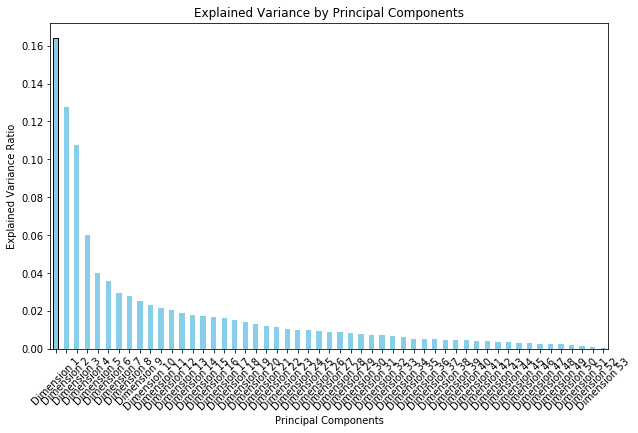

In [60]:
# Extract explained variance for plotting
explained_variance = pca_result_df['Explained Variance']

# Plot bar chart
plt.figure(figsize=(10, 6))
explained_variance.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(rotation=45)
plt.show

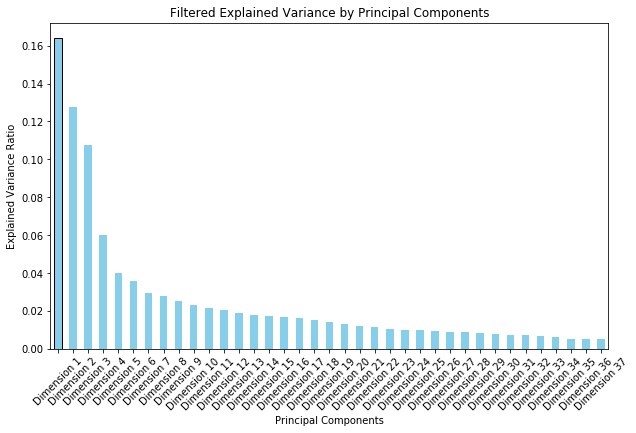

In [61]:

# Filter PCA results to keep components with explained variance >= 0.5%
filtered_pca_results = pca_result_df[pca_result_df['Explained Variance'] >= 0.005]

# Optional: Plot the filtered explained variance
plt.figure(figsize=(10, 6))
filtered_pca_results['Explained Variance'].plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Filtered Explained Variance by Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(rotation=45)
plt.show()

In [62]:
# Investigate the variance accounted for by each principal component.

# Compute the cumulative explained variance ratio
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components to reach at least 85% explained variance
n_components_85ev = np.argmax(cumulative_explained_variance >= 0.85) + 1

print(f"Number of components needed to explain at least 85% variability: {n_components_85ev}")

Number of components needed to explain at least 85% variability: 24


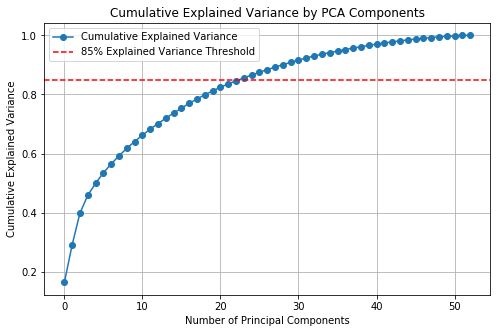

In [63]:
plt.figure(figsize=(8, 5))
plt.plot(cumulative_explained_variance, marker='o', label='Cumulative Explained Variance')
plt.axhline(y=0.85, color='r', linestyle='--', label='85% Explained Variance Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.legend()
plt.grid()
plt.show()

In [64]:
# Re-apply PCA to the data while selecting for number of components to retain.
n_components = 24
# Initialize PCA with selected components
pca_final = PCA(n_components=n_components)
# Fit and transform the data
pca_data_final = pca_final.fit_transform(scaled_data)

In [65]:
pca_data_final.shape

(790927, 24)

### Discussion 2.2: Perform Dimensionality Reduction

Based on the plot and calculation, Number of components needed to explain at least 85% variability is 24.
Therefore, the chosen number of component to keep is 24.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [94]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# Define a function to display sorted feature weights for a principal component
def plot_pca_weights(df, pca, component_index, threshold=0.1):
    feature_weights = pca.components_[component_index]
    features = df.columns
    weights = pd.Series(feature_weights, index=features)
    
    # Filter and sort by absolute weight
    weights_filtered = weights[weights.abs() >= threshold].sort_values()
    
    # Plot
    weights_filtered.plot(kind='barh', figsize=(8, 6))
    plt.axvline(0, color='black', linestyle='--', linewidth=1)  # Add vertical line at 0
    plt.title(f'PCA Component {component_index + 1}')
    plt.xlabel('Feature Weight')
    plt.ylabel('Feature')
    plt.show()
    
    # Print top 3 positive and top 3 negative weights
    print(f"\nTop 3 Positive Weights for PCA Component {component_index + 1}:")
    print(weights.nlargest(3))
    print(f"\nTop 3 Negative Weights for PCA Component {component_index + 1}:")
    print(weights.nsmallest(3))

feature_names = scaled_data.columns

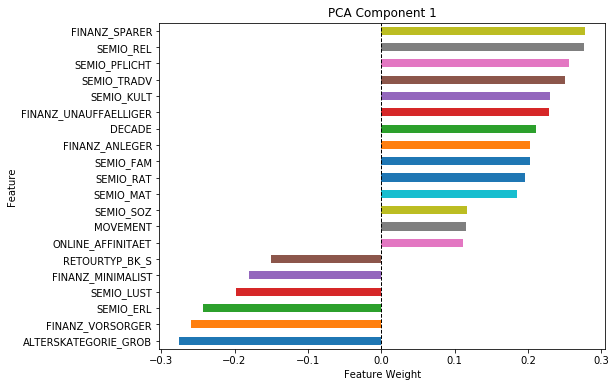

In [67]:
# Call the function for the first three principal components
plot_pca_weights(scaled_data, pca_final, component_index=0, threshold=0.1)

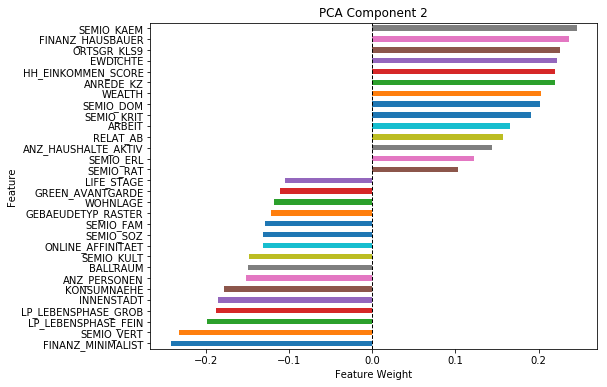

In [68]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plot_pca_weights(scaled_data, pca_final, component_index=1, threshold=0.1)

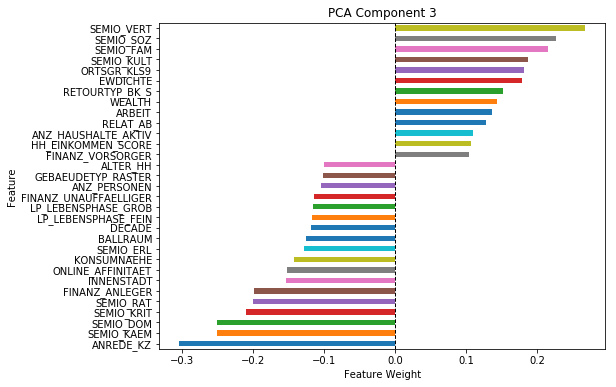

In [69]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plot_pca_weights(scaled_data, pca_final, component_index=2, threshold=0.1)

### Discussion 2.3: Interpret Principal Components

Summary of the first three principal components:

- PC1 (Financial Responsibility & Personality): Differentiates individuals based on financial habits, personality traits, and age group.

  Top Positive Features: 
   - Money-saving (FINANZ_SPARER)
   - religious (SEMIO_REL)
   - dutiful (SEMIO_PFLICHT).

  Top Negative Features: 
   - Age (ALTERSKATEGORIE_GROB)
   - preparedness (FINANZ_VORSORGER)
   - Event-oriented (SEMIO_ERL).


- PC2 (Ambition & Lifestyle Preferences): Highlights ambition and lifestyle contrasts between homeownership goals and minimalist or dreamful tendencies.

   Top Positive Features: 
   - Combative attitude (SEMIO_KAEM)
   - Homeownership (FINANZ_HAUSBAUER)
   - Community size (ORTSGR_KLS9).
   
   Top Negative Features: 
   - Financial minimalism (FINANZ_MINIMALIST)
   - Dreamful nature (SEMIO_VERT)
   - Life stage (LP_LEBENSPHASE_FEIN).
   
   
- PC3 (Sociability vs. Dominance): Distinguishes sociable, family-oriented traits from dominance and gender-related tendencies.

   Top Positive Features: 
   - Dreamful (SEMIO_VERT)
   - Socially-minded (SEMIO_SOZ)
   - Family-oriented (SEMIO_FAM).
   
   Top Negative Features: 
   - Gender (ANREDE_KZ)
   - Combative attitude (SEMIO_KAEM)
   - Dominance (SEMIO_DOM).

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [70]:
# Over a number of different cluster counts...
def get_kmeans_score(data, cluster_count):
    kmeans = KMeans(n_clusters=cluster_count)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

# Test cluster counts in steps of 3, from 3 to 30.
# tqdm for progress bar
scores = []
centers = range(3,30,3)
    
for i, k in enumerate(centers, start=1):
    print(f"Processing {i}/{len(centers)}: Testing {k} clusters...")
    try:
        score = get_kmeans_score(pca_data_final, k)
        scores.append(score)
        print(f"Clusters: {k}, Score: {score:.2f}")
    except Exception as e:
        print(f"Error fitting KMeans for {k} clusters: {e}")
        scores.append(None)

Processing 1/9: Testing 3 clusters...
Clusters: 3, Score: 28083893.24
Processing 2/9: Testing 6 clusters...
Clusters: 6, Score: 23585236.27
Processing 3/9: Testing 9 clusters...
Clusters: 9, Score: 21423421.17
Processing 4/9: Testing 12 clusters...
Clusters: 12, Score: 19910225.02
Processing 5/9: Testing 15 clusters...
Clusters: 15, Score: 18594759.39
Processing 6/9: Testing 18 clusters...
Clusters: 18, Score: 17598810.86
Processing 7/9: Testing 21 clusters...
Clusters: 21, Score: 17001210.95
Processing 8/9: Testing 24 clusters...
Clusters: 24, Score: 16470875.90
Processing 9/9: Testing 27 clusters...
Clusters: 27, Score: 16100055.32


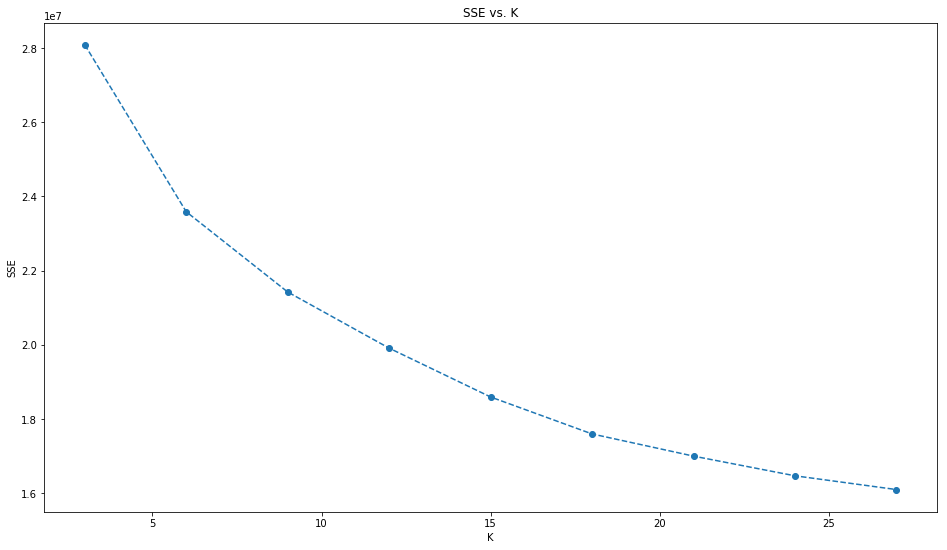

In [72]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# Plot
plt.figure(figsize=(16, 9))
plt.plot(centers, scores, marker='o', linestyle='--')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')
plt.legend()
plt.show()

In [73]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# Optimal cluster count based on elbow plot
optimal_k = 12

# Re-fit K-Means with the selected cluster count
kmeans = KMeans(optimal_k)
model =  kmeans.fit(pca_data_final)

In [74]:
# Predict cluster labels for the general population
gp_cluster_labels = model.predict(pca_data_final)

### Discussion 3.1: Apply Clustering to General Population

The sharp decrease in within-cluster sum of squares happens from 3 to 10
After K = 12, the curve starts to flatten, meaning additional clusters provide less improvement.

Optimal cluster count of 12 is chosen for a balanced choice, capturing meaningful cluster distinctions while avoiding overfitting or unnecessary complexity.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [98]:
# Load in the customer demographics data.
# Step 1 Load data
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

# Load general demographic data and process using clean_data to ensure similar process.
general = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

In [99]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Step 2 Clean data
cleaned_customer_df = clean_data(customers)
cleaned_general_df = clean_data(general)

Successfully created DECADE and MOVEMENT
Successfully created WEALTH and LIFE_STAGE
Successfully created DECADE and MOVEMENT
Successfully created WEALTH and LIFE_STAGE


In [100]:
cleaned_customer_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,ONLINE_AFFINITAET,KBA13_ANZAHL_PKW,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,4,1,5,1,5,1,2,2,0,1,1,20.0,5.0,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,0.0,10.0,2.0,0.0,1.0,9.0,1.0,0.000000,5.0,1992.0,0,7.0,3.0,2.0,4.0,4.0,3.0,1201.0,1.0,2.0,1.0,50,2,1,3
2,4,2,5,1,5,1,4,4,0,1,2,13.0,3.0,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,0.0,6.0,1.0,0.0,1.0,9.0,1.0,0.000000,1.0,1992.0,0,2.0,7.0,4.0,1.0,3.0,1.0,433.0,3.0,5.0,3.0,50,2,3,4
3,4,1,5,1,5,2,1,2,0,0,2,0.0,0.0,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0.0,8.0,0.0,0.0,4.0,9.0,0.0,0.067725,2.0,1992.0,0,7.0,7.0,1.0,7.0,4.0,2.0,755.0,1.0,3.0,1.0,40,1,2,4
4,3,1,3,1,4,4,5,2,1960,0,3,31.0,10.0,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,0.0,20.0,4.0,0.0,6.0,9.0,7.0,0.000000,1.0,1992.0,0,3.0,3.0,4.0,4.0,3.0,5.0,513.0,3.0,5.0,1.0,70,2,4,1
5,3,1,5,1,5,1,2,3,0,1,3,17.0,5.0,3.0,6,4,4,1,7,6,4,6,2,5,5,3,3,4,0.0,11.0,2.0,0.0,1.0,9.0,1.0,0.000000,2.0,1992.0,0,1.0,7.0,5.0,8.0,4.0,3.0,1167.0,3.0,7.0,5.0,50,2,3,4


In [101]:
cleaned_general_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,ONLINE_AFFINITAET,KBA13_ANZAHL_PKW,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1,2,1,5,2,5,4,5,1996,0,3,21.0,6.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,0.0,2.0,0.0,6.0,9.0,11.0,0.0,1.0,1992.0,0,4.0,6.0,3.0,8.0,3.0,3.0,963.0,3.0,5.0,4.0,90,2,5,1
2,3,2,1,4,1,2,3,5,1979,1,3,3.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,17.0,1.0,0.0,4.0,9.0,10.0,0.0,5.0,1992.0,0,2.0,2.0,4.0,4.0,4.0,2.0,712.0,3.0,5.0,2.0,90,1,2,4
3,4,2,4,2,5,2,1,2,1957,0,2,0.0,0.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,13.0,0.0,0.0,1.0,9.0,1.0,0.0,4.0,1997.0,0,7.0,4.0,2.0,6.0,4.0,1.0,596.0,2.0,3.0,3.0,70,2,1,2
4,3,1,4,3,4,1,3,2,1963,0,3,32.0,10.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,20.0,4.0,0.0,5.0,9.0,3.0,0.0,4.0,1992.0,0,3.0,2.0,5.0,1.0,5.0,5.0,435.0,4.0,6.0,5.0,70,2,4,3
5,1,2,3,1,5,2,2,5,1943,0,3,8.0,2.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,10.0,1.0,0.0,5.0,9.0,5.0,0.0,5.0,1992.0,0,7.0,6.0,2.0,7.0,4.0,1.0,1300.0,2.0,3.0,3.0,50,1,5,4


In [104]:
cleaned_customer_df.shape

(138300, 53)

In [105]:
cleaned_general_df.shape

(790973, 53)

In [107]:
# Ensure no missing value/data
print(f'Customer data Missing Value count: {cleaned_customer_df.isna().sum().sum()}')
print(f'General demographic data Missing Value count: {cleaned_general_df.isna().sum().sum()}')

Customer data Missing Value count: 0
General demographic data Missing Value count: 0


In [108]:
# Align customer data columns with general population columns

# Step 1: Scale data using the pre-fitted scaler from the general population
scaled_customer_data = scaler.transform(cleaned_customer_df)
scaled_general_data = scaler.transform(cleaned_general_df)

# Step 2: PCA transformation using the pre-fitted PCA object from the general population
general_pca = pca_final.transform(scaled_general_data)
customer_pca = pca_final.transform(scaled_customer_data)

print(f"PCA-transformed customer data shape: {customer_pca.shape}")
print(f"PCA-transformed general demographic data shape: {general_pca.shape}")

PCA-transformed customer data shape: (138300, 24)
PCA-transformed general demographic data shape: (790973, 24)


In [109]:
# Step 3: Predict clusters using the pre-trained KMeans model
customer_cluster_labels = model.predict(customer_pca)
general_cluster_labels = model.predict(general_pca)

# Step 4: Add cluster labels to the DataFrame
cleaned_general_df['Cluster'] = general_cluster_labels
cleaned_customer_df['Cluster'] = customer_cluster_labels

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [110]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Cluster proportions
gp_cluster_proportions = cleaned_general_df['Cluster'].value_counts(normalize=True)
customer_cluster_proportions = cleaned_customer_df['Cluster'].value_counts(normalize=True)

# Combine into a single DataFrame for easy comparison
proportions_df = pd.DataFrame({
    'Cluster': gp_cluster_proportions.index,
    'General Population': gp_cluster_proportions.values,
    'Customer Data': customer_cluster_proportions.reindex(gp_cluster_proportions.index, fill_value=0).values
})
proportions_df.set_index('Cluster', inplace=True)

print(proportions_df)

         General Population  Customer Data
Cluster                                   
1                  0.124732       0.111873
0                  0.124347       0.102784
11                 0.102427       0.010051
7                  0.101053       0.168973
9                  0.093595       0.075734
5                  0.091418       0.013926
4                  0.090832       0.120398
2                  0.089840       0.009978
6                  0.078942       0.343290
10                 0.075339       0.019935
3                  0.023231       0.002936
8                  0.004244       0.020123


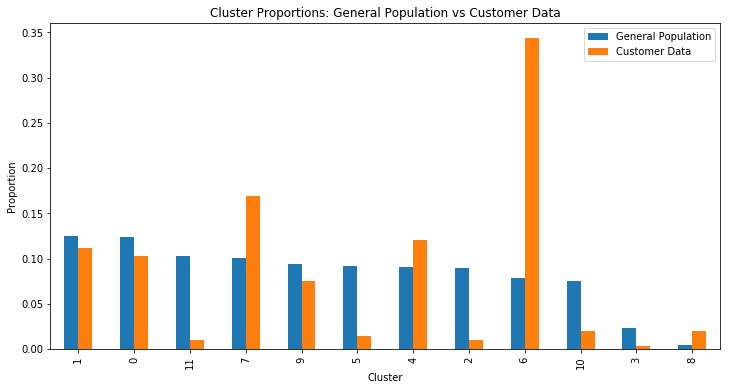

In [111]:
# Plot proportions
proportions_df.plot(kind='bar', figsize=(12, 6))
plt.title("Cluster Proportions: General Population vs Customer Data")
plt.ylabel("Proportion")
plt.xlabel("Cluster")
plt.show()

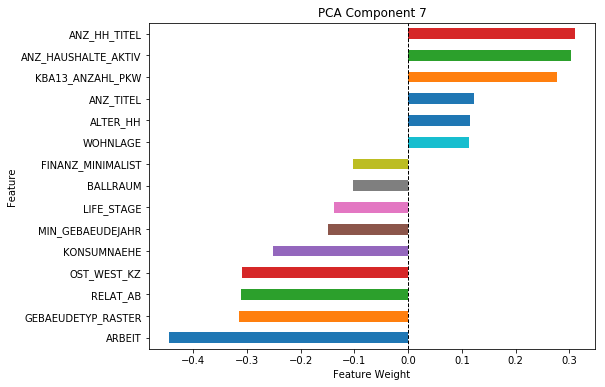


Top 3 Positive Weights for PCA Component 7:
ANZ_HH_TITEL           0.310144
ANZ_HAUSHALTE_AKTIV    0.303477
KBA13_ANZAHL_PKW       0.276949
dtype: float64

Top 3 Negative Weights for PCA Component 7:
ARBEIT               -0.444770
GEBAEUDETYP_RASTER   -0.315117
RELAT_AB             -0.310540
dtype: float64


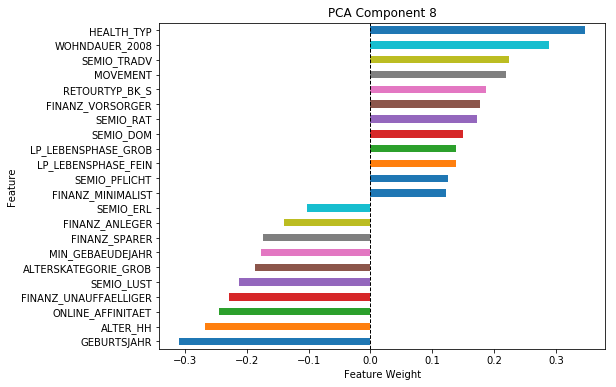


Top 3 Positive Weights for PCA Component 8:
HEALTH_TYP        0.346810
WOHNDAUER_2008    0.288386
SEMIO_TRADV       0.223731
dtype: float64

Top 3 Negative Weights for PCA Component 8:
GEBURTSJAHR         -0.308756
ALTER_HH            -0.266634
ONLINE_AFFINITAET   -0.244979
dtype: float64


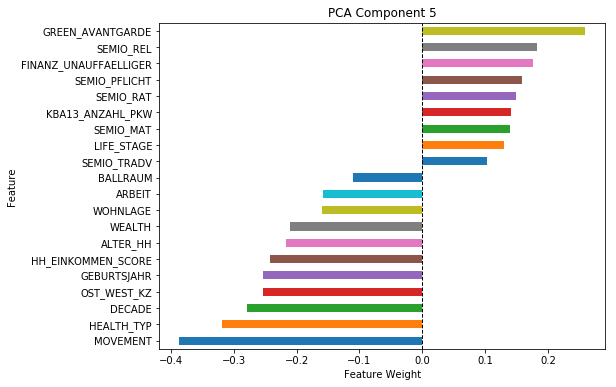


Top 3 Positive Weights for PCA Component 5:
GREEN_AVANTGARDE         0.259209
SEMIO_REL                0.181995
FINANZ_UNAUFFAELLIGER    0.176836
dtype: float64

Top 3 Negative Weights for PCA Component 5:
MOVEMENT     -0.386492
HEALTH_TYP   -0.319308
DECADE       -0.279349
dtype: float64


In [112]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# Example: Analyze features of Cluster 0

# Overrepresented, Cluster 6, 7 and 4
over_cluster_ids = [6,7,4]

for cluster_id in over_cluster_ids:
    plot_pca_weights(cleaned_customer_df.drop(columns=['Cluster']), 
                     pca_final, component_index=cluster_id, threshold=0.1)

Cluster 6: 
- ANZ_HH_TITEL: Number of professional academic title holders in building
- ANZ_HAUSHALTE_AKTIV: Number of households in the building
- KBA13_ANZAHL_PKW: Number of cars in the PLZ8 region

Cluster 7:
- HEALTH_TYP: Health typology
- WOHNDAUER_2008: Length of residence
- SEMIO_TRADV: tradional-minded

Cluster 4:
- GREEN_AVANTGARDE: Membership in environmental sustainability as part of youth
- SEMIO_REL: Religious
- FINANZ_UNAUFFAELLIGER: Financial inconspicuous

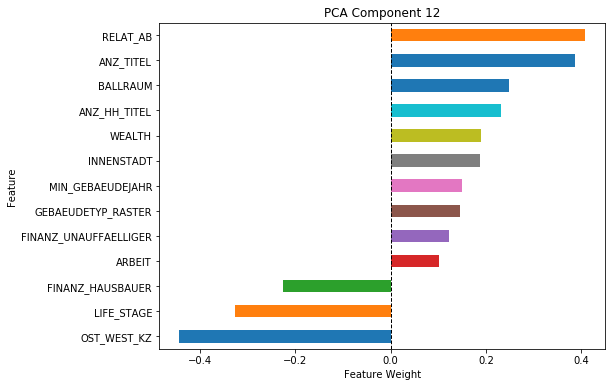


Top 3 Positive Weights for PCA Component 12:
RELAT_AB     0.408033
ANZ_TITEL    0.387425
BALLRAUM     0.249188
dtype: float64

Top 3 Negative Weights for PCA Component 12:
OST_WEST_KZ        -0.442586
LIFE_STAGE         -0.326536
FINANZ_HAUSBAUER   -0.225791
dtype: float64


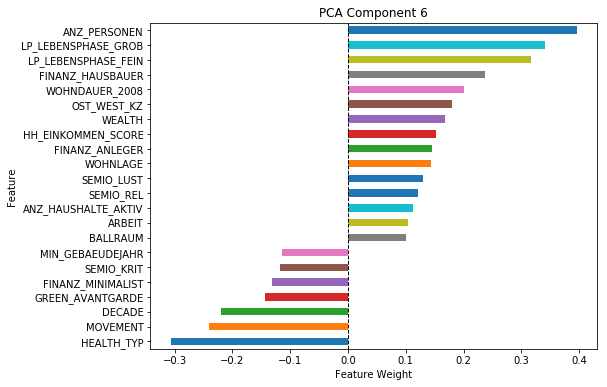


Top 3 Positive Weights for PCA Component 6:
ANZ_PERSONEN           0.395396
LP_LEBENSPHASE_GROB    0.340362
LP_LEBENSPHASE_FEIN    0.316645
dtype: float64

Top 3 Negative Weights for PCA Component 6:
HEALTH_TYP   -0.306628
MOVEMENT     -0.241211
DECADE       -0.219622
dtype: float64


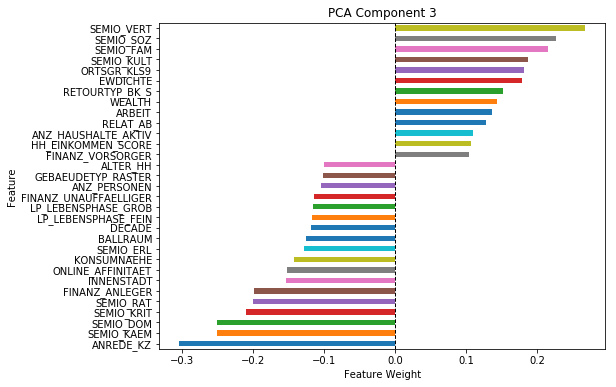


Top 3 Positive Weights for PCA Component 3:
SEMIO_VERT    0.267532
SEMIO_SOZ     0.226555
SEMIO_FAM     0.215015
dtype: float64

Top 3 Negative Weights for PCA Component 3:
ANREDE_KZ    -0.303870
SEMIO_KAEM   -0.251553
SEMIO_DOM    -0.250665
dtype: float64


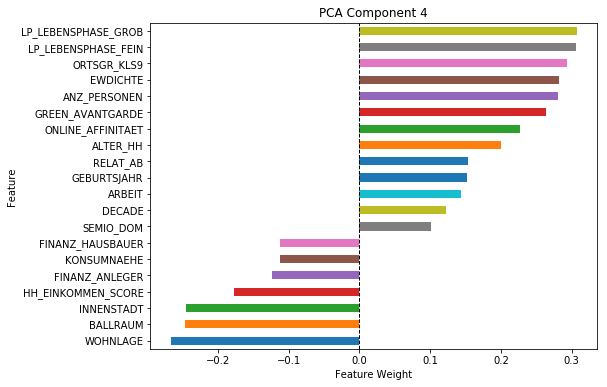


Top 3 Positive Weights for PCA Component 4:
LP_LEBENSPHASE_GROB    0.307029
LP_LEBENSPHASE_FEIN    0.306648
ORTSGR_KLS9            0.292840
dtype: float64

Top 3 Negative Weights for PCA Component 4:
WOHNLAGE     -0.266921
BALLRAUM     -0.246975
INNENSTADT   -0.244743
dtype: float64


In [113]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Overrepresented, Cluster 11, 5, 2 and 3
under_cluster_ids = [11, 5, 2, 3]

for cluster_id in under_cluster_ids:
    plot_pca_weights(cleaned_customer_df.drop(columns=['Cluster']), 
                     pca_final, component_index=cluster_id, threshold=0.1)

Cluster 11:
- RELAT_AB: Share of unemployment relative to county in which community is contained  
- ANZ_TITEL: Number of professional academic title holders in household
- BALLRAUM: Distance to nearest urban center

Cluster 5: 
- ANZ_PERSONEN: Number of adults in household
- LP_LEBENSPHASE_GROB: Life stage, rough scale
- LP_LEBENSPHASE_FEIN: Life stage, fine scale

Cluster 2:
- SEMIO_VERT:dreamful
- SEMIO_SOZ: socially-minded
- SEMIO_FAM: family-minded

### Discussion 3.3: Compare Customer Data to Demographics Data

### Summary
###### Company appeals most to the following population segments:
1. Affluent and active households (Cluster 6):
   - Households with multiple professionals and vehicles, indicating higher financial stability.
2. Traditional and health-conscious individuals (Cluster 7):
   - People with long-term residential stability, strong traditional values, and a focus on health.
3. Environmentally conscious and religious individuals (Cluster 4):
   - Financially stable individuals with a strong focus on sustainability and religious values.

These overrepresented clusters suggest the company’s core customer base, representing a financially responsible, stable, and value-driven audience.

######  Company struggles to engage the following segments:
1. Rural and economically constrained households (Cluster 11):
   - Individuals in rural areas facing economic challenges but with some educational attainment.
2. Larger households with diverse life stages (Cluster 5): 
   - Households with more adults, varying in life stages, potentially representing complex purchasing needs.
3. Social and family-oriented individuals (Cluster 2): 
   - Dreamful, socially active, and family-focused individuals, who may not align with the company’s marketing strategy.

These underrepresented clusters suggest the company has limited reach or appeal in rural regions, larger households, or socially-focused demographics.
   
###### Conclusion for their marketing strategy.

1. Focus on strengths:
   - Target affluent, health-conscious, and value-driven segments (Clusters 6, 7, 4) with premium, personalized products emphasizing quality, tradition, and environmental values.
2. Engage Untapped Markets:
   - Offer affordable, family-oriented bundles to attract larger households, rural communities, and socially active individuals (Clusters 11, 5, 2).

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.